# Transfer the 2D from scikit-learn

1. `prior`: mean, var, degree of smoothness (over a given length scale)
2. observed data pts with some noise lvl
3. apply bayes theorem to obtain a new `posterior` dist'n of funcs
* mean pass through data, reduced var near to data pts.
4. use posterior mean to pred unseen samples, interpret the posterior var as a measure of uncertainty in those pred.

yet for N data pts, need N by N matrix, expensive --> length scale & noise lvl r unkown in practice, selecting their val \
needs optimisation process, hence GP does NOT scale well to large data sets.

1st I will follow the tut of scikit-learn, then I will make the transfer afterwards.

## scikit-learn tut

### 2D GP regre in sk-learn

Suppose we have a few samples of a function of two variables  z(x,y). We wish to interpolate  z \
  using Gaussian process regression over the available data. For this example, we consider the quadratic surface,


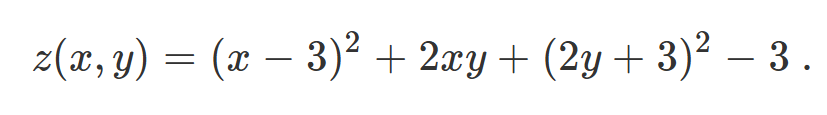

#### Preliminaries

In [44]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split

np.random.seed(17)  # So you can reproduce these results at home

evaluating  z over a regular grid to represent our ground truth:

In [45]:
nv = 20  # Number of points in each direction
xv = np.linspace(-5.,5.,nv)  # x-vector
yv = np.linspace(-5.,5.,nv)  # y-vector
x, y = np.meshgrid(xv, yv)  # x and y are (nv, nv) matrices
# the function
z = (x-3.)**2. + 2.*x*y + (2.*y+3.)**2. - 3.

add noise

In [46]:
noise_level = 5.
z_noisy = z + np.random.normal(size=x.shape) * noise_level

scikit-learn expects each input and output as column vectors, so we must reshape the grid:

In [47]:
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1,1)

#### Performing the fit

need to first specify out `proir` functional dist'n, and use kernel (mathematical function, to specify how smooth the func should be) \
kernel quantifies correlation (or covariance) btw 2 pts in our input space (2d here)
- For example, points closer together might be more strongly correlated than points farther apart.
- The kernel essentially encodes how changes in one part of the function relate to changes in another, ensuring a certain degree of smoothness or regularity.

In [48]:
# In Gaussian Processes, length scales determine how far points in the input space can influence each other. 
# A longer length scale indicates smoother variations, while a shorter length scale indicates more localized influence.
guess_l = (2., 1.)  # In general, x and y have different scales
bounds_l = ((1e-1,100.),) * 2  # Same bounds for x and y (0.1 to 100)
guess_n = 1.  # Amount of noise
bounds_n = (1e-20, 10.) # Bounds for noise
kernel = (  # Kernel objects can simply be summed using +
    RBF(length_scale=guess_l, length_scale_bounds=bounds_l)
    + WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)
)

5% for training, rest for test

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)

At last, we can do the fitting. Passing `normalize_y=True` scales the function values to zero mean and unit variance before fitting. \
This is equivalent to choosing `priors`: 
- the `mean` of z is equal to the training sample mean; 
- and the `variance` of z is equal to the training sample variance.

In [50]:
gpr = GaussianProcessRegressor(kernel, normalize_y=True )
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=[2, 1]) + WhiteKernel(noise_level=1),
                         normalize_y=True)

inspect the fitted kernel params:

In [51]:
print(gpr.kernel_)
# RBF(length_scale=[7.86, 3.71]) + WhiteKernel(noise_level=0.00678)

RBF(length_scale=[7.86, 3.71]) + WhiteKernel(noise_level=0.00678)


#### Plotting the results

With our fitted regressor object, we can evaluate the `posterior` mean and standard deviation over the input data, and convert back to a grid for plotting:

In [52]:
Zfit, Zstd = gpr.predict(X, return_std=True)
zstd = Zstd.reshape(x.shape)
zfit = Zfit.reshape(x.shape)

First, compare the true function with the fitted posterior mean:

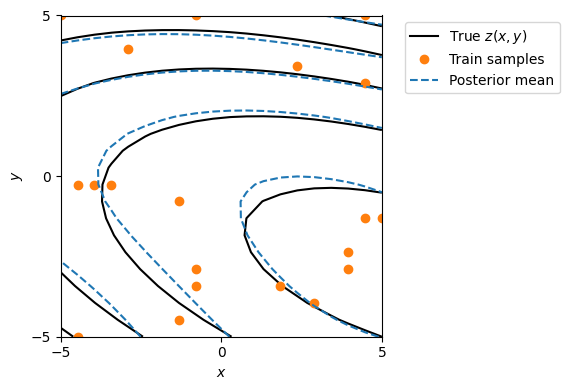

In [53]:
# Set up figure
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')
ax.set_xticks((-5,0,5))
ax.set_yticks((-5,0,5))
ax.grid(False)

# Do the plotting
lev = np.linspace(0.,250.,6)  # Defines contour levels ranging from 0 to 250, split into 6 evenly spaced intervals. 
ax.contour(x,y,z,lev,colors='k')  # Truth
ax.plot(*X_train.T,'o',color="C1")  # Training samples
ax.contour(x, y,zfit, lev, colors='C0', linestyles='dashed')  # Posterior mean

# Legend
truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker="o", linestyle="none", label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle="--", label='Posterior mean')
ax.legend(handles=[truth_line, sample_line, mean_line],bbox_to_anchor=(1.05, 1), loc="upper left")

# Write out
plt.tight_layout()
plt.savefig('gpr_posterior_mean.svg')

The figure shows good agreement between the contours.
Second, plot the variation in posterior standard deviation.

C:\Users\shend\AppData\Local\Temp\ipykernel_45272\1057023286.py:16: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for hci in hc.collections:


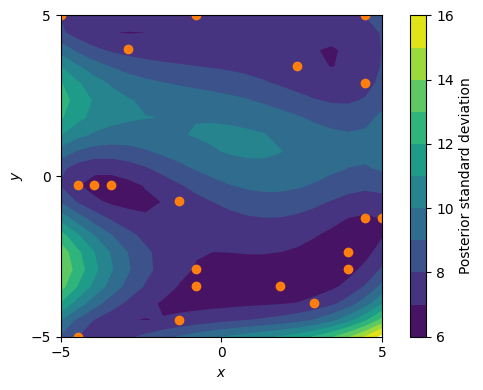

In [54]:
# Set up figure
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')
ax.set_xticks((-5,0,5))
ax.set_yticks((-5,0,5))
ax.grid(False)

# Do the plotting
ax.plot(*X_train.T,'o',color="C1")  # Training samples
lev = np.linspace(6.,16.,11)
hc = ax.contourf(x, y, zstd, lev)  # Posterior std
for hci in hc.collections:
  hci.set_edgecolor("face")

# Colorbar
hcb = plt.colorbar(hc)
hcb.ax.grid(False)
hcb.set_label('Posterior standard deviation')

# Write out
plt.tight_layout()
plt.savefig('gpr_posterior_std.svg')


#### Bonus one-linear

Here is a shell command that extracts all code blocks from a markdown file and writes them out to a new Python script:

`jupyter nbconvert --to script your_notebook.ipynb`

## Transfer to Gpytorch

### Basic Equation

z(x, y) = (x - 3)^2 + 2xy + (2y + 3)^2 - 3

#### Gpytorch Perliminaries

In [55]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(41)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2D data

In [56]:
nv = 20  # Number of points in each direction
xv = np.linspace(-5.,5.,nv)  # x-vector
yv = np.linspace(-5.,5.,nv)  # y-vector
x, y = np.meshgrid(xv, yv)  # x and y are (nv, nv) matrices

# true the function
z = (x-3.)**2. + 2.*x*y + (2.*y+3.)**2. - 3.

In [57]:
noise_level = 5.
z_noisy = z + np.random.normal(size=x.shape) * noise_level

In [58]:
# Flatten the data for training
X = np.column_stack((x.ravel(), y.ravel()))  # shape (nv*nv, 2)
Z = z_noisy.ravel()  # shape (nv*nv,)

In [59]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95, random_state=42)

In [60]:
# Convert to torch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float)
Y_train_t = torch.tensor(Y_train, dtype=torch.float)
X_test_t = torch.tensor(X_test, dtype=torch.float)
Y_test_t = torch.tensor(Y_test, dtype=torch.float)

#### GPytorch Model

In [61]:
# ExactGPModel from gpytorch that we need to form the model together
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        # Mean module (can also try ZeroMean, ConstantMean, etc.)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # RBF kernel with ARD for 2D input, scaled by a separate outputscale
        self.covar_module = gpytorch.kernels.ScaleKernel(
            base_kernel=gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Set up & Training

In [62]:
# Define likelihood (noise)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Create GP model
model = ExactGPModel(X_train_t, Y_train_t, likelihood)

In [63]:
# Initialize hyperparameters (if desired)
#   - By default, GPyTorch will learn these from data,
#     but you can initialize them similarly to the scikit guesses:
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0, 1.0])  # guess 1
model.likelihood.noise = 1.0  # guess 1

# Optionally, set constraints similar to scikit's bounds:
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)
model.likelihood.raw_noise_constraint = gpytorch.constraints.Interval(1e-20, 10.0)

In [64]:
# Switch to training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Marginal Log-Likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [65]:
# define training_itreations
training_iterations = 500

In [66]:
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = -mll(output, Y_train_t)
    loss.backward()
    
    
    if (i+1) % 5 == 0:
        print(
            f"Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.detach().numpy()} "
            f"noise: {model.likelihood.noise.item():.3f}"
        )
        
    optimizer.step()

Iter 5/500 - Loss: 1698.933 lengthscale: [[90.454025 53.545834]] noise: 1.269
Iter 10/500 - Loss: 1303.046 lengthscale: [[93.65318  40.896935]] noise: 1.630
Iter 15/500 - Loss: 1037.228 lengthscale: [[95.52168  28.945345]] noise: 1.991
Iter 20/500 - Loss: 837.135 lengthscale: [[96.62298  18.925596]] noise: 2.327
Iter 25/500 - Loss: 670.539 lengthscale: [[97.27275  11.487369]] noise: 2.624
Iter 30/500 - Loss: 534.505 lengthscale: [[97.59573    6.6262584]] noise: 2.874
Iter 35/500 - Loss: 398.037 lengthscale: [[97.6241     3.6846635]] noise: 3.078
Iter 40/500 - Loss: 333.136 lengthscale: [[97.40002    2.1190445]] noise: 3.235
Iter 45/500 - Loss: 313.538 lengthscale: [[96.96525    1.4687294]] noise: 3.356
Iter 50/500 - Loss: 298.177 lengthscale: [[96.3339     1.2168944]] noise: 3.451
Iter 55/500 - Loss: 283.411 lengthscale: [[95.4688     1.1292284]] noise: 3.529
Iter 60/500 - Loss: 269.947 lengthscale: [[94.22802    1.1180863]] noise: 3.596
Iter 65/500 - Loss: 258.212 lengthscale: [[92.24

#### Fit and pred 

In [67]:
# Convert entire grid X to torch
X_all_t = torch.tensor(X, dtype=torch.float)

In [68]:
# Switch to eval mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (raw_noise_constraint): Interval(1.000E-20, 1.000E+01)
)

In [69]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_all_t))
    Zmean = preds.mean
    Zstd = preds.stddev

In [70]:
# Convert back to numpy
Zmean = Zmean.numpy()
Zstd = Zstd.numpy()

# Reshape to the original 2D grid
zfit = Zmean.reshape(x.shape)
zstd = Zstd.reshape(x.shape)

#### Plotting the results

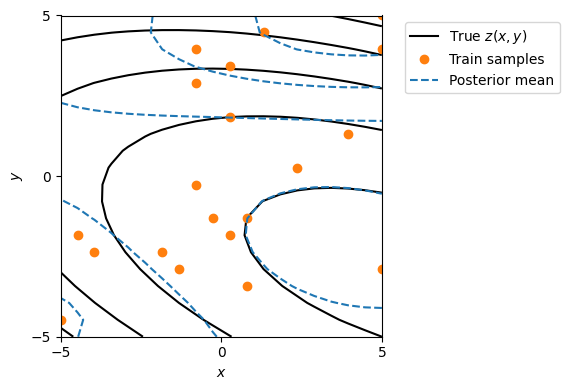

In [71]:
# Set up figure
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')
ax.set_xticks((-5,0,5))
ax.set_yticks((-5,0,5))
ax.grid(False)

# Do the plotting
lev = np.linspace(0.,250.,6)  # Defines contour levels ranging from 0 to 250, split into 6 evenly spaced intervals. 
ax.contour(x,y,z,lev,colors='k')  # Truth
ax.plot(*X_train.T,'o',color="C1")  # Training samples
ax.contour(x, y,zfit, lev, colors='C0', linestyles='dashed')  # Posterior mean

# Legend
truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker="o", linestyle="none", label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle="--", label='Posterior mean')
ax.legend(handles=[truth_line, sample_line, mean_line], bbox_to_anchor=(1.05, 1), loc="upper left")

# Write out
plt.tight_layout()
plt.savefig('gpytorch_gpr_posterior_mean.svg')
plt.show()

C:\Users\shend\AppData\Local\Temp\ipykernel_45272\1604118857.py:19: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for hci in hc.collections:


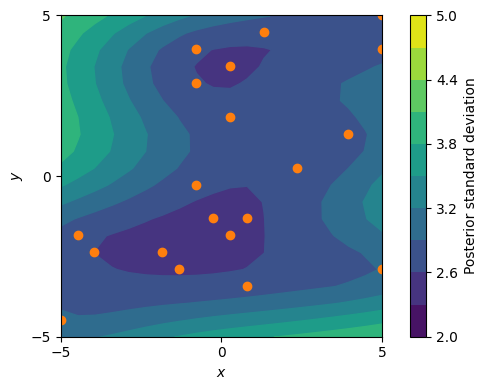

In [80]:
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')
ax.set_xticks((-5,0,5))
ax.set_yticks((-5,0,5))
ax.grid(False)

# Plot training samples
ax.plot(*X_train.T, 'o', color="C1")

# Levels for the standard deviation contours
lev_std = np.linspace(math.floor(zstd.min()), math.ceil(zstd.max()), 11)

# Contour fill of posterior standard deviation
hc = ax.contourf(x, y, zstd, lev_std)
for hci in hc.collections:
    hci.set_edgecolor("face")

# Colorbar
hcb = plt.colorbar(hc)
hcb.ax.grid(False)
hcb.set_label('Posterior standard deviation')

plt.tight_layout()
plt.savefig('gpytorch_posterior_std.svg')
plt.show()

In [76]:
print("zstd min =", zstd.min(), "zstd max =", zstd.max())

zstd min = 2.4822843 zstd max = 4.1258373
